## Assignment 1 - Econ262A

Author: David Henning

In [1]:
import numpy as np
import statsmodels.api as sm
import linearmodels as ln
import pandas as pd
from statsmodels.sandbox.regression.gmm import IV2SLS
from pystout import pystout
from tabulate import tabulate
import matplotlib.pyplot as plt
from stargazer.stargazer import Stargazer
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

### Question 1

In [2]:
#Simulate data
np.random.seed(1)
X = np.random.normal(loc=0, scale=1, size=10000)
Z = np.random.randint(2, size=10000)
u, ε = np.random.multivariate_normal([0, 0], [[1, 0.25], [0.25, 1]], (10000)).T

T = np.empty(10000)
for i in range(len(T)):
    T[i] = 1 if -0.5 + 0.25 * X[i] + Z[i] + u[i] > 0 else 0

Y = 0.5 * X + T + ε

data =  np.vstack((Y, X, T, Z, u, ε)).T

#### Question 1.1

In [3]:
data =  np.vstack((Y, X, T, Z, u, ε)).T
df = pd.DataFrame(data=data, columns=["Y", "X", "T", "Z", "u", "ε"])

In [4]:
#1) OLS regression of Y on X and T
x = df[['X','T']]
y = df[['Y']]
m1 = sm.OLS(y, x).fit()

#2) OLS regression of T on Z and X
x = df[['X','Z']]
y = df[['T']]
m2 = sm.OLS(y, x).fit()

#2) OLS regression of T on Z and X
x = df[['X','T']]
z = df[['X','Z']]
y = df[['Y']]
m3 = IV2SLS(Y, x, instrument=z).fit()

#stargazer = Stargazer([m1, m2, m3])

In [5]:
#Produce table with regression results
pystout(models=[m1, m2, m3],
        file='simulated_iv1.tex',
        digits=3,
        endog_names=['Y','T','Y'],
        exogvars=['T', 'Z', 'X'],
        #varlabels={'price':'Price','prom':'Promtion'},
        stars=False,
        mgroups={'OLS':[1,2], 'IV':3},
        modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}'}
        )

#### Question 1.2

In [6]:
α, u, ε = np.random.multivariate_normal([1, 0, 0], [[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]], (10000)).T

T = np.empty(10000)
for i in range(len(T)):
    T[i] = 1 if -0.5 + 0.25 * X[i] + Z[i] + u[i] > 0 else 0

Y = 0.5 * X + α * T + ε

In [7]:
data =  np.vstack((Y, X, T, Z, u, ε, α)).T
df = pd.DataFrame(data=data, columns=["Y", "X", "T", "Z", "u", "ε", "α"])

In [8]:
#1) OLS regression of Y on X and T
x = df[['X','T']]
y = df[['Y']]
m1 = sm.OLS(y, x).fit()

#2) OLS regression of T on Z and X
x = df[['X','Z']]
y = df[['T']]
m2 = sm.OLS(y, x).fit()

#2) OLS regression of T on Z and X
x = df[['X','T']]
z = df[['X','Z']]
y = df[['Y']]
m3 = IV2SLS(Y, x, instrument=z).fit()


In [9]:
#Produce table with regression results
pystout(models=[m1, m2, m3],
        file='simulated_iv2.tex',
        digits=3,
        endog_names=['Y','T','Y'],
        exogvars=['T', 'Z', 'X'],
        #varlabels={'price':'Price','prom':'Promtion'},
        stars=False,
        mgroups={'OLS':[1,2], 'IV':3},
        modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}'}
        )

Plot the dsitribution of $Y$ for always takers and never takers.

In [10]:
a = df[(df['Z']==0) & (df['T']==1)] #Define always takers
n = df[(df['Z']==1) & (df['T']==0)] #Define never takers
c = df[(df['Z'] == df['T'])] #Define compliers
Z1 = df[(df['Z']==1)]
Z0 = df[(df['Z']==0)]

φ_n = n.shape[0]/Z1.shape[0]
φ_a = a.shape[0]/Z0.shape[0]
φ_c = 1 - φ_n - φ_a

In [11]:
c0 = df[(df['Z']==0) & (df['T']==0)]
y_c0 = c0['Y']
c1 = df[(df['Z']==1) & (df['T']==1)]
y_c1 = c1['Y']

y_n = n['Y']
y_a = a['Y']

In [12]:
distributions = [y_a, y_n, y_c0, y_c1]
y_min = min(df['Y'])
y_max = max(df['Y'])
mylist = []

for i in distributions:
    y_d = np.linspace(y_min, y_max, 2000)
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(i[:, None])

    # score_samples returns the log of the probability density
    y = np.exp(kde.score_samples(y_d[:, None]))
    mylist.append(y)

In [13]:
g_a = mylist[0]
g_n = mylist[1]

g_c0 = ((φ_n + φ_c) / φ_c) * mylist[2] - (φ_n / φ_c) * g_n
g_c1 = ((φ_a + φ_c) / φ_c) * mylist[3] - (φ_a / φ_c) * g_a

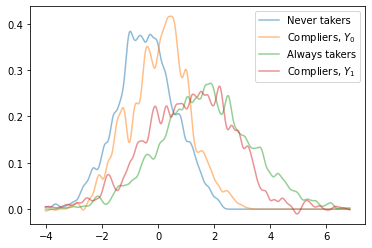

In [14]:
f = plt.figure()
plt.plot(y_d, g_n, alpha=0.5, label='Never takers')
plt.plot(y_d, g_c0, alpha=0.5, label='Compliers, $Y_0$')
plt.plot(y_d, g_a, alpha=0.5, label='Always takers')
plt.plot(y_d, g_c1, alpha=0.5, label='Compliers, $Y_1$')
plt.legend()
f.savefig("Y.pdf", bbox_inches='tight')

In [15]:
x = df['X']
x_n = n['X']
x_a = a['X']

distributions = [x_a, x_n, x]
x_min = min(df['X'])
x_max = max(df['X'])

x_distributions = []

for i in distributions:
    x_d = np.linspace(x_min, x_max, 2000)
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(i[:, None])
    
    # score_samples returns the log of the probability density
    x = np.exp(kde.score_samples(x_d[:, None]))
    
    x_distributions.append(x)

In [16]:
g_xa = x_distributions[0]
g_xn = x_distributions[1]
g_x = (1 / φ_c) * x_distributions[2] -  (φ_n/ φ_c) * g_xn - (φ_a / φ_c) * g_xa

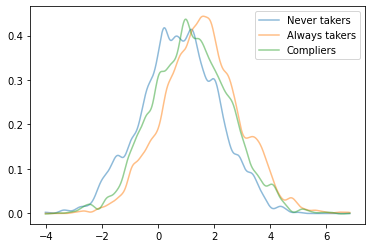

In [17]:
f = plt.figure()
plt.plot(y_d, g_xn, alpha=0.5, label='Never takers')
plt.plot(y_d, g_xa, alpha=0.5, label='Always takers')
plt.plot(y_d, g_x, alpha=0.5, label='Compliers')
plt.legend()
f.savefig("X.pdf", bbox_inches='tight')

In [18]:
α = df['α']
α_n = n['α']
α_a = a['α']

distributions = [α_a, α_n, α]
α_min = min(df['α'])
α_max = max(df['α'])

α_distributions = []

for i in distributions:
    α_d = np.linspace(α_min, α_max, 2000)
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(i[:, None])
    
    # score_samples returns the log of the probability density
    α = np.exp(kde.score_samples(α_d[:, None]))
    
    α_distributions.append(α)

In [19]:
g_αa = α_distributions[0]
g_αn = α_distributions[1]
g_α = (1 / φ_c) * α_distributions[2] -  (φ_n/ φ_c) * g_αn - (φ_a / φ_c) * g_αa

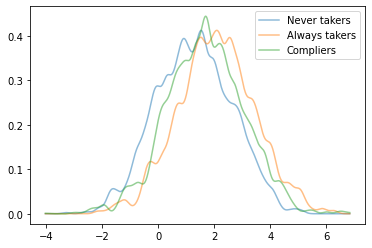

In [20]:
f = plt.figure()
plt.plot(y_d, g_αn, alpha=0.5, label='Never takers')
plt.plot(y_d, g_αa, alpha=0.5, label='Always takers')
plt.plot(y_d, g_α, alpha=0.5, label='Compliers')
plt.legend()
f.savefig("alpha.pdf", bbox_inches='tight')